In [1]:
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as sstats
from glob import glob
import numpy as np

from utils import SimulateData

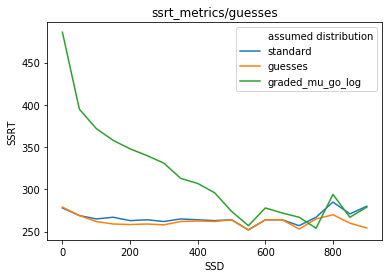

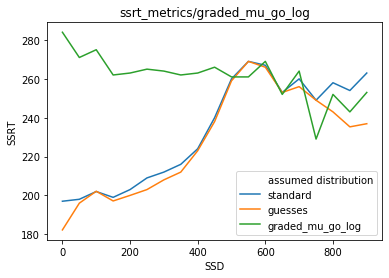

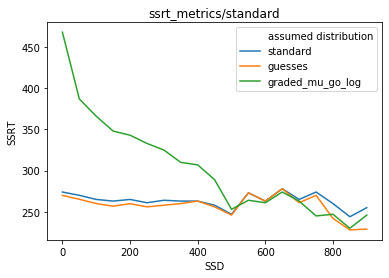

In [2]:
full_metric_df = pd.DataFrame()

full_melt = pd.DataFrame()

for file in glob('ssrt_metrics/*.csv'):
    title = file.split('indiv_')[-1].replace('.csv', '')
    data =  pd.read_csv(file, index_col=0)
    data.columns = data.columns.str.replace('SSRT_', '')
    data = data.rename(columns={'SSRT': 'standard', 'w_guesses': 'guesses', 'w_graded': 'graded_mu_go_log'})
    melt_df = pd.melt(data, id_vars=['SSD'], value_vars=['standard','guesses','graded_mu_go_log'], var_name = 'assumed distribution', value_name='SSRT')
    melt_df['underlying distribution'] = title
    full_melt = pd.concat([full_melt, melt_df], 0)
    
    
    _ = sns.lineplot(x='SSD', y='SSRT', hue='assumed distribution', data=melt_df)
    
    plt.title(title)
    plt.show()
    plt.close()
    
    # for inhibition function
    data['underlying distribution'] = title
    full_metric_df = pd.concat([full_metric_df, data], 0)
#     curr_series = data.loc[:,['mean_SSD', 'p_respond']].set_index('mean_SSD').add_prefix(title+'_')
#     p_respond_df = pd.concat([p_respond_df, curr_series], 1)

# organize ssrt metric data

In [3]:
full_metric_df = pd.DataFrame()

full_melt = pd.DataFrame()

for file in [i for i in glob('ssrt_metrics/*.csv') if 'linear' not in i]:
    title = file.split('/')[-1].replace('.csv', '')
    data =  pd.read_csv(file, index_col=0)
    data.columns = data.columns.str.replace('SSRT_', '')
    data = data.rename(columns={'SSRT': 'standard', 'w_guesses': 'guesses', 'w_graded': 'graded_mu_go_log'})
    melt_df = pd.melt(data, id_vars=['SSD'], value_vars=['standard', 'guesses', 'graded_mu_go_log'], var_name = 'assumed distribution', value_name='SSRT')
    melt_df['underlying distribution'] = title
    full_melt = pd.concat([full_melt, melt_df], 0)
    
    # for inhibition function
    data['underlying distribution'] = title
    full_metric_df = pd.concat([full_metric_df, data], 0)
#     curr_series = data.loc[:,['mean_SSD', 'p_respond']].set_index('mean_SSD').add_prefix(title+'_')
#     p_respond_df = pd.concat([p_respond_df, curr_series], 1)

# SSRT by SSD

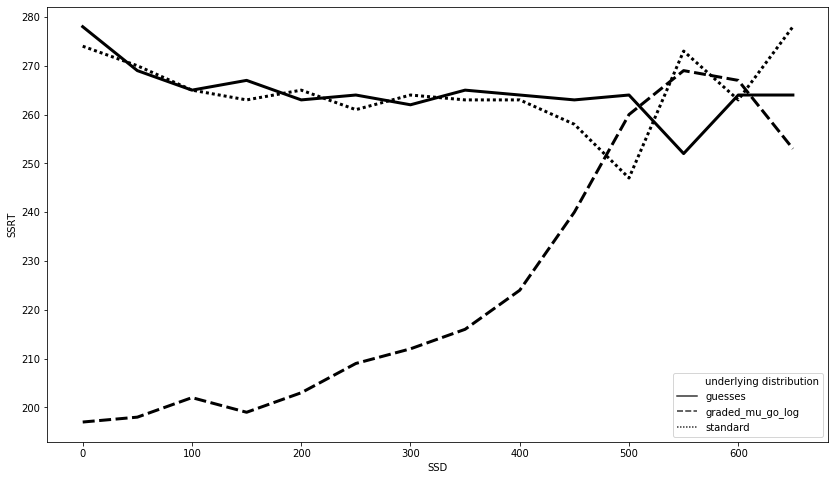

In [4]:
fig,ax = plt.subplots(1,1, figsize=(14, 8))
_ = sns.lineplot(x='SSD', y='SSRT', color='k', style='underlying distribution', data=full_melt[(full_melt['assumed distribution'] == 'standard') & (full_melt['SSD'] <= 650)], linewidth=3)
plt.savefig('figures/SSRT_by_SSD.png')

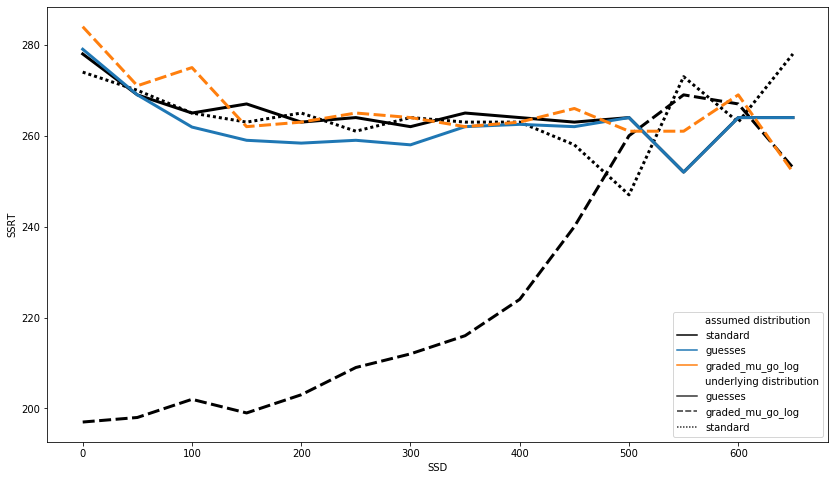

In [5]:
fig,ax = plt.subplots(1,1, figsize=(14, 8))
keep_idx = ((full_melt['assumed distribution'] == 'standard') | (full_melt['assumed distribution'] == full_melt['underlying distribution'])) & (full_melt['SSD'] <= 650)
_ = sns.lineplot(x='SSD', y='SSRT', hue='assumed distribution', style='underlying distribution', data=full_melt[keep_idx], palette=['k', '#1f77b4', '#ff7f0e'], linewidth=3)
plt.savefig('figures/SSRT_by_SSD_supplement.png')

In [6]:
full_metric_df[full_metric_df['underlying distribution'] == 'graded_mu_go_log']

,standard,mean_SSD,p_respond,max_RT,mean_go_RT,mean_stopfail_RT,omission_count,omission_rate,go_acc,stopfail_acc,SSD,guesses,graded_mu_go_log,underlying distribution
0,197.0,0.0,0.10680,2597.0,422.5806,267.130618,0,0.0,NaN,NaN,0.0,182.231233,284.0,graded_mu_go_log
1,198.0,50.0,0.23190,2597.0,422.5806,273.337214,0,0.0,NaN,NaN,50.0,196.000000,271.0,graded_mu_go_log
2,202.0,100.0,0.37125,2597.0,422.5806,285.349360,0,0.0,NaN,NaN,100.0,202.139886,275.0,graded_mu_go_log
3,199.0,150.0,0.47700,2597.0,422.5806,297.636688,0,0.0,NaN,NaN,150.0,197.140398,262.0,graded_mu_go_log
4,203.0,200.0,0.57950,2597.0,422.5806,312.288783,0,0.0,NaN,NaN,200.0,200.000000,263.0,graded_mu_go_log
5,209.0,250.0,0.66895,2597.0,422.5806,326.933627,0,0.0,NaN,NaN,250.0,203.000000,265.0,graded_mu_go_log
6,212.0,300.0,0.73880,2597.0,422.5806,339.048795,0,0.0,NaN,NaN,300.0,208.000000,264.0,graded_mu_go_log
7,216.0,350.0,0.79350,2597.0,422.5806,348.405230,0,0.0,NaN,NaN,350.0,212.000000,262.0,graded_mu_go_log
8,224.0,400.0,0.84105,2597.0,422.5806,357.751977,0,0.0,NaN,NaN,400.0,223.000000,263.0,graded_mu_go_log
9,240.0,450.0,0.87975,2597.0,422.5806,364.762887,0,0.0,NaN,NaN,450.0,238.000000,266.0,graded_mu_go_log


In [7]:
full_melt[full_melt['underlying distribution'] == 'graded_mu_go_log']

,SSD,assumed distribution,SSRT,underlying distribution
0,0.0,standard,197.000000,graded_mu_go_log
1,50.0,standard,198.000000,graded_mu_go_log
2,100.0,standard,202.000000,graded_mu_go_log
3,150.0,standard,199.000000,graded_mu_go_log
4,200.0,standard,203.000000,graded_mu_go_log
5,250.0,standard,209.000000,graded_mu_go_log
6,300.0,standard,212.000000,graded_mu_go_log
7,350.0,standard,216.000000,graded_mu_go_log
8,400.0,standard,224.000000,graded_mu_go_log
9,450.0,standard,240.000000,graded_mu_go_log


# Inhibition Function

In [8]:
abcd_inhib_func = pd.read_csv('abcd_data/abcd_inhib_func.csv')

In [9]:
inhib_func_df = pd.concat([full_metric_df[['SSD', 'p_respond', 'underlying distribution']], abcd_inhib_func], 0)

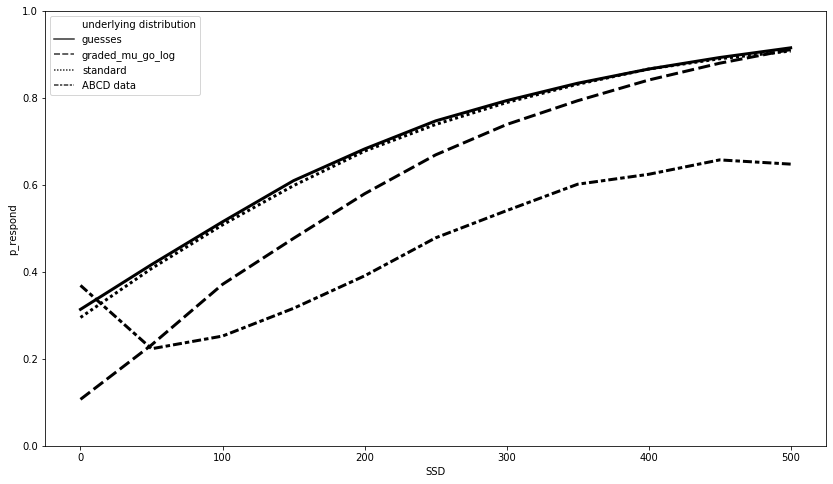

In [10]:
fig,ax = plt.subplots(1,1, figsize=(14, 8))
_ = sns.lineplot(x='SSD', y='p_respond', color='k', style='underlying distribution', data=inhib_func_df.query('SSD <= 500'), linewidth=3)
plt.ylim([0,1])
plt.savefig('figures/inhibition_function.png')

# Individual Differences

In [11]:
ABCD_SSD_dists = pd.read_csv('abcd_data/SSD_dist_by_subj.csv')
ABCD_SSD_dists

,NARGUID,SSDDur,proportion
0,003RTV85,300.0,0.250000
1,003RTV85,250.0,0.183333
2,003RTV85,400.0,0.183333
3,003RTV85,350.0,0.166667
4,003RTV85,450.0,0.100000
...,...,...,...
64043,xxmy9wd8,100.0,0.183333
64044,xxmy9wd8,150.0,0.133333
64045,xxmy9wd8,200.0,0.116667
64046,xxmy9wd8,250.0,0.100000


In [12]:
indiv_SSRTs = pd.DataFrame()
for file in glob('ssrt_metrics/*.csv'):
    data =  pd.read_csv(file, index_col=0)
    
    gen_str = file.split('/')[-1].replace('.csv', '')
    indiv_ssrt_df = pd.DataFrame(np.nan, index=ABCD_SSD_dists.NARGUID.unique(), columns=['vanilla', 'w_guesses', 'w_graded'])
    for sub in ABCD_SSD_dists.NARGUID.unique():
        curr_sub = ABCD_SSD_dists.query("NARGUID=='%s'" % sub)
        indiv_ssrt_df.loc[sub, :] = [0, 0, 0]
        for SSD in curr_sub.SSDDur:
            ssd_SSRTs = data.loc[data.SSD==SSD, ['SSRT', 'SSRT_w_guesses', 'SSRT_w_graded']].values[0]
            weight = curr_sub.loc[curr_sub.SSDDur==SSD, 'proportion'].values
            indiv_ssrt_df.loc[sub, :] +=  ssd_SSRTs * weight
    indiv_SSRTs = pd.concat([indiv_SSRTs, indiv_ssrt_df.add_prefix('gen-%s_SSRT-' % gen_str)], 1)

In [15]:
indiv_ssrt_df

,vanilla,w_guesses,w_graded
003RTV85,262.633333,258.889980,320.450000
00CY2MDM,268.433333,263.552367,394.950000
00HEV6HB,266.716667,261.812520,376.550000
00LJVZK2,265.433333,261.104361,348.850000
00NPMHND,263.666667,262.047969,281.266667
...,...,...,...
hkfm1ruj,262.100000,259.147064,316.316667
hx1ru4hv,265.933333,260.763173,368.300000
jf8w3pw6,264.950000,259.637702,356.216667
x8k59,264.383333,259.253919,348.133333


In [16]:
indiv_SSRTs.filter(regex='SSRT-vanilla').corr(method='spearman')

,gen-guesses_SSRT-vanilla,gen-graded_mu_go_log_SSRT-vanilla,gen-standard_SSRT-vanilla
gen-guesses_SSRT-vanilla,1.000000,-0.845608,0.859238
gen-graded_mu_go_log_SSRT-vanilla,-0.845608,1.000000,-0.898200
gen-standard_SSRT-vanilla,0.859238,-0.898200,1.000000


# Plot graded Mu Go function

In [17]:
SSDs = np.arange(0,650, 5)

simulator = SimulateData()
mu_gos = [[i, simulator._log_mu_go(1, i)] for i in SSDs]

/Users/henrymj/Documents/ABCD_simulations/utils.py:268: RuntimeWarning: divide by zero encountered in log
  return self._at_least_0((np.log(SSD/max_SSD)/4+1) * mu_go)


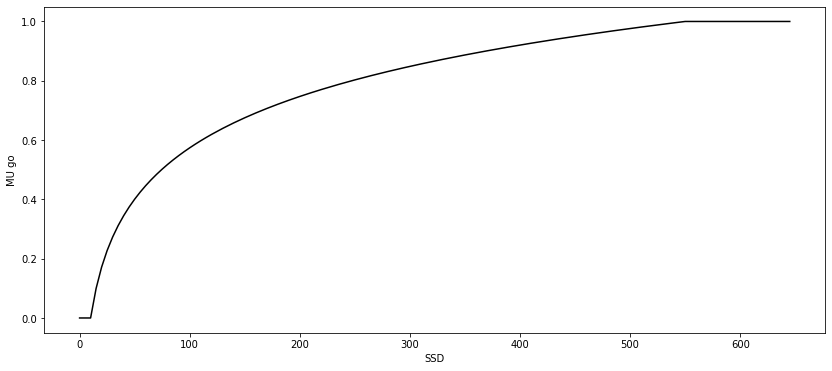

In [18]:
fig,ax = plt.subplots(1,1, figsize=(14, 6))

_ = sns.lineplot(x='SSD', y='MU go', color='k', data=pd.DataFrame(mu_gos, columns=['SSD', 'MU go']))
plt.savefig('figures/graded_mu_go_function.png')